In [17]:
import torch
from torchvision import transforms
from functorch import make_functional, vmap, vjp, jvp, jacrev
from torchvision import datasets
import torch.utils.data as loader
from matplotlib import pyplot as plt
import numpy as np
from numpy import linalg as LA
import torch.nn as nn
from numpy.random import default_rng
import pandas as pd
import seaborn as sns
rng = default_rng()

In [3]:
device = 'cpu'

## NTK functions

In [4]:
# Functions from https://pytorch.org/functorch/stable/notebooks/neural_tangent_kernels.html
def fnet_single(params, x):
    # unsqueeze returns a new tensor with a dimension of size one inserted at the specified position.
    # squeeze removes dimension at specified position.
    return fnet(params, x.unsqueeze(0)).squeeze(0)


def empirical_ntk_jacobian_contraction(fnet_single, params, x1, x2):
    # Compute J(x1)
    jac1 = vmap(jacrev(fnet_single), (None, 0))(params, x1)
    jac1 = [j.flatten(2) for j in jac1]

    # Compute J(x2)
    jac2 = vmap(jacrev(fnet_single), (None, 0))(params, x2)
    jac2 = [j.flatten(2) for j in jac2]

    # Compute J(x1) @ J(x2).T
    result = torch.stack([torch.einsum('Naf,Mbf->NMab', j1, j2) for j1, j2 in zip(jac1, jac2)])
    result = result.sum(0)
    return result

# Models

In [116]:
class FNN(nn.Module):
    def __init__(self, m, L, act):
        super(FNN, self).__init__()
        self.d = d # dimension of square image (i.e., image has shape 3*d*d)
        self.L = L # number of hidden layers
        
        # Select activation function
        if act == 'relu':
            self.act = nn.ReLU()
        elif act == 'tanh':
            self.act = nn.Tanh()
        elif act == 'linear':
            self.act = nn.Identity()
        else:
            print("Activation not recognized, using ReLU instead")
            self.act = nn.ReLU()
        
        # Define layers
        self.fcin = nn.Linear(3*d*d, m)
        self.fchid = nn.Linear(m, m)
        self.fcout = nn.Linear(m, 1)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1, end_dim=- 1)  
        x = self.fcin(x)
        x = self.act(x)
        
        for i in range(self.L-1):
            x = self.fchid(x)
            x = self.act(x)
                
        x = self.fcout(x)
        return x

In [117]:
class CNN(nn.Module):
    def __init__(self, n_c, L, act):
        super(CNN, self).__init__()
        self.d = d # dimension of square image
        self.L = L # number of hidden layers
        
        # Select activation function
        if act == 'relu':
            self.act = nn.ReLU()
        elif act == 'tanh':
            self.act = nn.Tanh()
        elif act == 'linear':
            self.act = nn.Identity()               
        else:
            print("Activation not recognized, using ReLU instead")
            self.act = nn.ReLU()
        
        # Define layers
        self.conv1 = nn.Conv2d(3, n_c, (5, 5))
        self.conv2 = nn.Conv2d(n_c, n_c, (5, 5))
        self.fc = nn.Linear(n_c*(d - 4*L)*(d - 4*L), 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act(x)
        
        for i in range(self.L-1):
            x = self.conv2(x)
            x = self.act(x)
        
        x = torch.flatten(x, start_dim=1, end_dim=- 1)        
        x = self.fc(x)
        return x

# Import caltech 101 data

In [177]:
d = 40 # assume images are square and have d pixels per side

In [179]:
path = "/Users/mjm/Desktop/datasets/caltech101/101_ObjectCategories"
T = transforms.Compose([
    transforms.RandomResizedCrop(size=d),
#     transforms.RandomCrop(size=d),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
c101_data = datasets.ImageFolder(root=path, transform=T)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


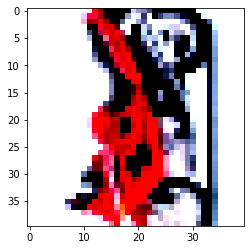

In [180]:
img_ex = (c101_data[2000][0]).permute(2,1,0).numpy()
plt.imshow(img_ex)

# Generate NTK matrices

In [181]:
batch_size = 200
n_trials = 10
m = 500
n_c = 100

In [182]:
df = pd.DataFrame(columns = ["tn", "ds", "type", "act", "L", "evi", "ev"])
for t in range(n_trials):
    for ds in ['c101', 'gauss']:
        if ds == 'c101':
           # Generate Caltec101 data for this trial
            batch = torch.empty((batch_size, 3, d, d))
            ri = rng.choice(len(c101_data), size=batch_size, replace=False)
            for j in range(batch_size):
                batch[j] = c101_data[ri[j]][0]
        else:
            # Generate Gaussian data for this trial
            batch = torch.randn(batch_size, 3, d, d)
               
        for act in ['relu', 'tanh', 'linear']:
            for L in [2, 5]:
                for typ in ['fnn', 'cnn']:
                    if typ == 'fnn':
                        model = FNN(m,L,act)
                    else:
                        model = CNN(n_c,L,act)   
                    fnet, params = make_functional(model)
                    temp = empirical_ntk_jacobian_contraction(fnet_single, params, batch, batch).squeeze()
                    ntk_matrix = temp.detach().numpy()
                    eigs,_= LA.eig(ntk_matrix)
                    eigs_sort = np.sort(eigs)[::-1]
                    eigs_sort = eigs_sort/eigs_sort[0]
                    temp_dict = {"tn":[t for i in range(batch_size)],
                        "ds": [ds for i in range(batch_size)],
                        "type": [typ for i in range(batch_size)],
                        "act": [act for i in range(batch_size)],
                        "L": [L for i in range(batch_size)],
                        "evi": np.arange(1,batch_size+1),
                        "ev": eigs_sort
                    }
                    temp_df = pd.DataFrame(temp_dict)
                    df = pd.concat([df, temp_df], ignore_index = True)

        # Compute spectrum of data
        data_matrix = batch.flatten(1).detach().numpy()
        data_gram = data_matrix@data_matrix.T
        eigs,_=LA.eig(data_gram)
        eigs_sort = np.sort(eigs)[::-1]
        eigs_sort = eigs_sort/eigs_sort[0]
        
        temp_dict = {"tn":[t for i in range(batch_size)],
            "ds": [ds for i in range(batch_size)],
            "type": ['data' for i in range(batch_size)],
            "act": ['data' for i in range(batch_size)],
            "L": [L for i in range(batch_size)],
            "evi": np.arange(1,batch_size+1),
            "ev": eigs_sort
        }
        temp_df = pd.DataFrame(temp_dict)
        df = pd.concat([df, temp_df], ignore_index = True)
        
    print("Completed trial " + str(t+1))

Completed trial 1
Completed trial 2
Completed trial 3
Completed trial 4
Completed trial 5
Completed trial 6
Completed trial 7
Completed trial 8
Completed trial 9
Completed trial 10


In [183]:
# Save dataframe to 
df.to_csv("spectral_data2.csv",index=False)

# Plots

In [184]:
name_dict = {"tn":"tn",
            "ds": "ds",
            "type": "type",
            "act": "Activation",
            "L": "L",
            "evi": "Eigenvalue Index",
            "ev": "Normalized Magnitude"}
# call rename () method
df.rename(columns=name_dict,
          inplace=True)

In [185]:
# Slice up the data
df_100 = df[(df['Eigenvalue Index']<101)]

# Get data data-frame
df_data = df_100[df_100["type"]=="data"]
df_data_c101 = df_data[df_data["ds"]=="c101"]
df_data_gauss = df_data[df_data["ds"]=="gauss"]

# Generate data frames for cnn
df_cnn = df_100[df_100["type"]=="cnn"]
df_cnn_2_c101 = df_cnn[(df_cnn["L"]==2)&(df_cnn["ds"]=="c101")]
df_cnn_5_c101 =  df_cnn[(df_cnn["L"]==5)&(df_cnn["ds"]=="c101")]
df_cnn_2_gauss = df_cnn[(df_cnn["L"]==2)&(df_cnn["ds"]=="gauss")]
df_cnn_5_gauss =  df_cnn[(df_cnn["L"]==5)&(df_cnn["ds"]=="gauss")]

# Generate data frames for fnn
df_fnn = df_100[df_100["type"]=="fnn"]
df_fnn_2_c101 = df_fnn[(df_fnn["L"]==2)&(df_fnn["ds"]=="c101")]
df_fnn_5_c101 =  df_fnn[(df_fnn["L"]==5)&(df_fnn["ds"]=="c101")]
df_fnn_2_gauss = df_fnn[(df_fnn["L"]==2)&(df_fnn["ds"]=="gauss")]
df_fnn_5_gauss =  df_fnn[(df_fnn["L"]==5)&(df_fnn["ds"]=="gauss")]

### Feedforward neural networks spectra

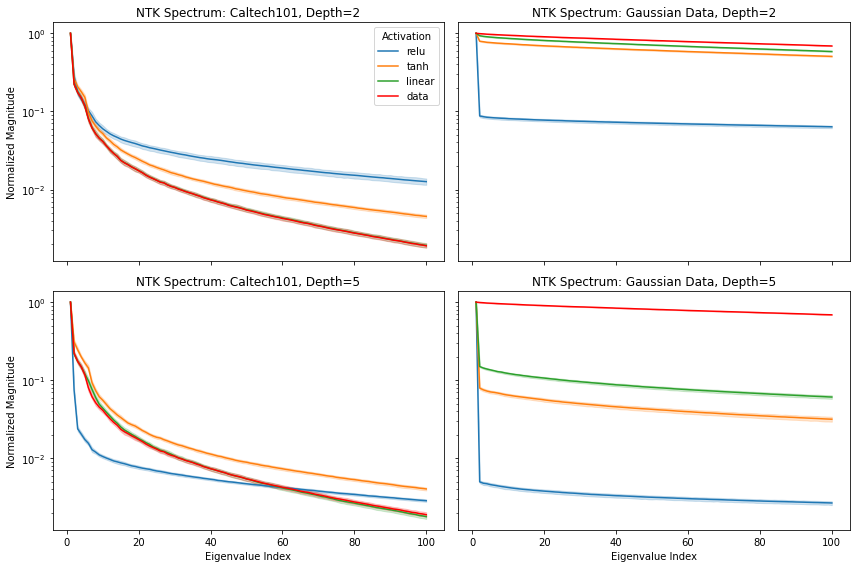

In [214]:
fig1, ax = plt.subplots(2,2, figsize=(12,8), sharex=True, sharey=True)
sns.lineplot(data=df_fnn_2_c101, x="Eigenvalue Index", y="Normalized Magnitude", hue="Activation", ax = ax[0,0]).set(title='NTK Spectrum: Caltech101, Depth=2')
sns.lineplot(data=df_data_c101,  x="Eigenvalue Index", y="Normalized Magnitude", hue="Activation",palette=['red'], ax = ax[0,0])
sns.lineplot(data=df_fnn_5_c101, x="Eigenvalue Index", y="Normalized Magnitude", hue="Activation", ax = ax[1,0]).set(title='NTK Spectrum: Caltech101, Depth=5')
sns.lineplot(data=df_data_c101,  x="Eigenvalue Index", y="Normalized Magnitude", hue="Activation",palette=['red'], ax = ax[1,0])
sns.lineplot(data=df_fnn_2_gauss, x="Eigenvalue Index", y="Normalized Magnitude", hue="Activation", ax = ax[0,1]).set(title='NTK Spectrum: Gaussian Data, Depth=2')
sns.lineplot(data=df_data_gauss,  x="Eigenvalue Index", y="Normalized Magnitude", hue="Activation",palette=['red'], ax = ax[0,1])
sns.lineplot(data=df_fnn_5_gauss, x="Eigenvalue Index", y="Normalized Magnitude", hue="Activation", ax = ax[1,1]).set(title='NTK Spectrum: Gaussian Data, Depth=5')
sns.lineplot(data=df_data_gauss,  x="Eigenvalue Index", y="Normalized Magnitude", hue="Activation",palette=['red'], ax = ax[1,1])
ax[0,0].set_yscale('log')
ax[0,1].get_legend().remove()
ax[1,0].get_legend().remove()
ax[1,1].get_legend().remove()
fig.suptitle('FFNN Architecture', fontsize=12)
plt.tight_layout()

In [215]:
fig1.savefig("fnn_spectrums2.png")

### Convolutional neural networks

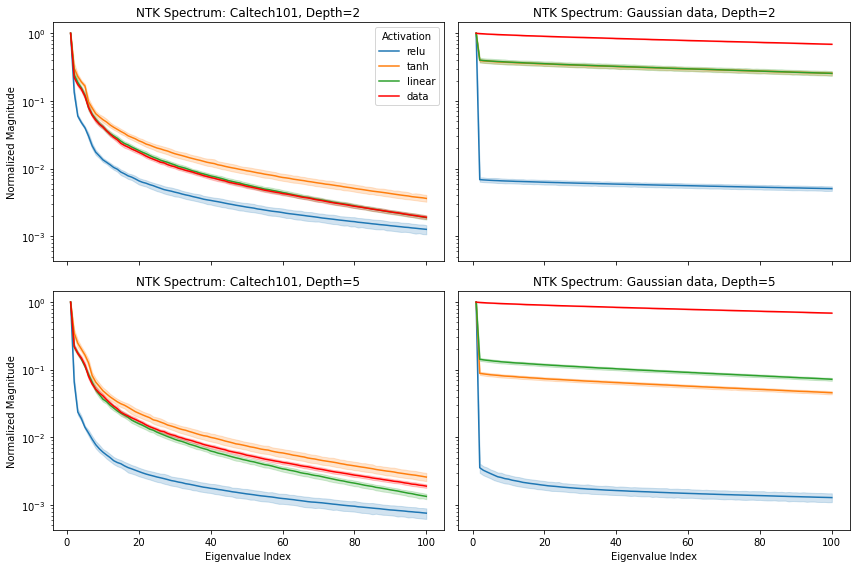

In [216]:
fig2, ax = plt.subplots(2,2, figsize=(12,8), sharex=True, sharey=True)
sns.lineplot(data=df_cnn_2_c101, x="Eigenvalue Index", y="Normalized Magnitude", hue="Activation", ax = ax[0,0]).set(title='NTK Spectrum: Caltech101, Depth=2')
sns.lineplot(data=df_data_c101,  x="Eigenvalue Index", y="Normalized Magnitude", hue="Activation",palette=['red'], ax = ax[0,0])
sns.lineplot(data=df_cnn_5_c101, x="Eigenvalue Index", y="Normalized Magnitude", hue="Activation", ax = ax[1,0]).set(title='NTK Spectrum: Caltech101, Depth=5')
sns.lineplot(data=df_data_c101,  x="Eigenvalue Index", y="Normalized Magnitude", hue="Activation",palette=['red'], ax = ax[1,0])
sns.lineplot(data=df_cnn_2_gauss, x="Eigenvalue Index", y="Normalized Magnitude", hue="Activation", ax = ax[0,1]).set(title='NTK Spectrum: Gaussian data, Depth=2')
sns.lineplot(data=df_data_gauss,  x="Eigenvalue Index", y="Normalized Magnitude", hue="Activation",palette=['red'], ax = ax[0,1])
sns.lineplot(data=df_cnn_5_gauss, x="Eigenvalue Index", y="Normalized Magnitude", hue="Activation", ax = ax[1,1]).set(title='NTK Spectrum: Gaussian data, Depth=5')
sns.lineplot(data=df_data_gauss,  x="Eigenvalue Index", y="Normalized Magnitude", hue="Activation",palette=['red'], ax = ax[1,1])
ax[0,0].set_yscale('log')
ax[0,1].get_legend().remove()
ax[1,0].get_legend().remove()
ax[1,1].get_legend().remove()
fig.suptitle('CNN Architecture', fontsize=12)
plt.tight_layout()

In [217]:
fig2.savefig("cnn_spectrums2.png")